## Prediction of Significant Wave Height in Korea Strait using Machine Learning

## Import

In [ ]:
## pip install 'h5py==2.10.0' --force-reinstall

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'
# CPU :'os.environ["CUDA_VISIBLE_DEVICES"]='-1' , GPU :'os.environ["CUDA_VISIBLE_DEVICES"]='0'
import pandas as pd
from pandas import Timestamp
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import math
np.random.seed(777)
tf.random.set_seed(777)

In [2]:
print(tf.__version__)
tf.test.gpu_device_name()

2.0.0


'/device:GPU:0'

## Load data

In [3]:
data = pd.read_csv('data/data_KS.csv')
data.dtypes

Date_Time        object
Cur_Vel         float64
Cur_Dir_deg       int64
Water_Temp      float64
Salty           float64
Sig_Wave_H      float64
Sig_Wave_P      float64
Max_Wave_H      float64
Max_Wave_P      float64
Wave_Dir_deg      int64
Wind_Vel        float64
Wind_Dir_deg      int64
Air_Temp        float64
Air_Pressure    float64
dtype: object

## Check exist of NaN data & Type conversion (float)

In [4]:
data.shape == data.dropna().shape # True: NaN data is not exist
data.iloc[:,1:13] = data.iloc[:,1:13].astype('float64')
data.Date_Time = data.Date_Time.astype('datetime64[ns]')

## Direction data conversion

In [5]:
Cur_Dir_cos = np.cos(data.Cur_Dir_deg*np.pi/180)
Cur_Dir_cos = Cur_Dir_cos.rename("Cur_Dir_cos")
Cur_Dir_sin = np.sin(data.Cur_Dir_deg*np.pi/180)
Cur_Dir_sin = Cur_Dir_sin.rename("Cur_Dir_sin")
Wind_Dir_cos = np.cos(data.Wind_Dir_deg*np.pi/180)
Wind_Dir_cos = Wind_Dir_cos.rename("Wind_Dir_cos")
Wind_Dir_sin = np.sin(data.Wind_Dir_deg*np.pi/180)
Wind_Dir_sin = Wind_Dir_sin.rename("Wind_Dir_sin")
data = pd.concat([data, Cur_Dir_cos, Cur_Dir_sin, Wind_Dir_cos, Wind_Dir_sin], axis=1)

In [6]:
pd.set_option('display.width', 140)
print(data)

                Date_Time  Cur_Vel  Cur_Dir_deg  Water_Temp  Salty  Sig_Wave_H  Sig_Wave_P  Max_Wave_H  Max_Wave_P  Wave_Dir_deg  \
0     2012-11-16 16:00:00    0.497         49.0        15.3  33.09        1.47         5.4        2.30         4.5         188.0   
1     2012-11-16 16:30:00    0.240         29.0        15.5  33.05        1.48         5.5        2.22         9.0          45.0   
2     2012-11-16 17:00:00    0.232         11.0        15.5  33.03        1.43         6.1        2.59         5.0          36.0   
3     2012-11-16 17:30:00    0.152         25.0        15.5  33.04        1.43         6.8        2.40        10.0          39.0   
4     2012-11-16 18:00:00    0.158         37.0        15.5  33.06        1.39         6.4        2.34         8.0          51.0   
...                   ...      ...          ...         ...    ...         ...         ...         ...         ...           ...   
98872 2020-12-31 21:30:00    0.166         78.0        14.7  34.09        1.

## Data slicing

In [7]:
data_train = data[data.Date_Time.between('2014-01-01 00:00:00', '2018-12-31 23:30:00')]
data_valid = data[data.Date_Time.between('2019-01-01 00:00:00', '2019-12-31 23:30:00')]
data_test = data[data.Date_Time.between('2020-01-01 00:00:00', '2020-12-31 23:30:00')]

## Neural Network

In [8]:
caseNum = 3
if caseNum==1:
    inputFeature = ['Wind_Vel', 'Wind_Dir_cos','Wind_Dir_sin'] # CaseNum = 1-1
    degIndex = [1,2]
elif caseNum == 2: 
    inputFeature = ['Wind_Vel', 'Wind_Dir_cos','Wind_Dir_sin', 'Cur_Vel', 'Cur_Dir_cos','Cur_Dir_sin'] # CaseNum = 2-2
    degIndex = [1,2,4,5]
elif caseNum == 3:
    inputFeature = ['Wind_Vel', 'Wind_Dir_cos','Wind_Dir_sin', 'Cur_Vel', 'Cur_Dir_cos', 'Cur_Dir_sin', 'Water_Temp', 'Salty', 'Air_Temp', 'Air_Pressure'] # CaseNum = 3-1
    degIndex = [1,2,4,5]

In [9]:
oX_data_train = data_train.loc[:, inputFeature].to_numpy()
oX_data_valid = data_valid.loc[:, inputFeature].to_numpy()
oX_data_test = data_test.loc[:, inputFeature].to_numpy()
print(np.array_str(oX_data_train, precision=2, suppress_small=True))
oX_data_train.shape

[[  11.4     0.12    0.99 ...   29.3    10.7  1011.2 ]
 [  10.2     0.29    0.96 ...   29.88   10.4  1011.4 ]
 [  10.      0.31    0.95 ...   28.33   10.3  1011.7 ]
 ...
 [   4.     -0.99   -0.16 ...   31.52   12.9  1020.8 ]
 [   4.3    -0.98    0.19 ...   31.82   12.8  1020.4 ]
 [   5.9    -0.83    0.56 ...   31.53   12.2  1020.  ]]


(72920, 10)

## Standardization

In [10]:
X_mean_train = oX_data_train.mean(axis=0)
std_train = oX_data_train.std(axis=0)
X_data_train = oX_data_train - X_mean_train
X_train = X_data_train / std_train
X_data_valid = oX_data_valid - X_mean_train
X_valid = X_data_valid / std_train
X_data_test = oX_data_test - X_mean_train
X_test = X_data_test / std_train
X_train[:,degIndex]=oX_data_train[:,degIndex]
X_valid[:,degIndex]=oX_data_valid[:,degIndex]
X_test[:,degIndex]=oX_data_test[:,degIndex]
print(np.array_str(X_train, precision=2))
X_train.shape

[[ 1.02  0.12  0.99 ... -0.01 -0.18 -0.55]
 [ 0.74  0.29  0.96 ...  0.09 -0.2  -0.53]
 [ 0.7   0.31  0.95 ... -0.16 -0.21 -0.49]
 ...
 [-0.7  -0.99 -0.16 ...  0.35 -0.03  0.73]
 [-0.63 -0.98  0.19 ...  0.4  -0.04  0.68]
 [-0.26 -0.83  0.56 ...  0.35 -0.08  0.63]]


(72920, 10)

## Input Y data set-up

In [11]:
Y_train = data_train.Sig_Wave_H.to_numpy()
Y_valid = data_valid.Sig_Wave_H.to_numpy()
Y_test = data_test.Sig_Wave_H.to_numpy()

## Input data set-up for FFNN2

In [12]:
def generate_X2(data, n_steps):
    batch_size = data.shape[0]-n_steps+1
    X_series = np.zeros((batch_size, n_steps, data.shape[-1]))
    for ii in range(batch_size):
        X_series[ii] = data[ii:ii+n_steps]
    return X_series

In [13]:
def generate_Y2(data, n_steps):
    batch_size = data.shape[0]-n_steps+1
    X_series = np.zeros((batch_size))
    for ii in range(batch_size):
        X_series[ii] = data[ii+n_steps-1]
    return X_series

In [14]:
n_steps = 24  # Squence data (48 = 1 day), (720 = 15days), (1440 = 30days)

mX_train = generate_X2(X_train, n_steps)
mY_train = generate_Y2(Y_train, n_steps)
mX_valid = generate_X2(X_valid, n_steps)
mY_valid = generate_Y2(Y_valid, n_steps)
mX_test = generate_X2(X_test, n_steps)
mY_test = generate_Y2(Y_test, n_steps)

#### https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

In [15]:
len(inputFeature)

10

In [ ]:
## 2021-06-04 n_steps = 16
stepNum = [64, -32, -16, -8]
layerNum = [2, 4, 6, 7] # Hidden layer # 10
batchNum = 256 # Batch num
epochNum = 500 # EpochNum
dropNum = 0.001 # Drop out Num
regularNum = 0.00001

In [ ]:
## 2021-06-05 n_steps = 16
stepNum = [64, -32, -16, -8]
layerNum = [4, 6, 9, 9] # Hidden layer # 10
batchNum = 256 # Batch num
epochNum = 500 # EpochNum
dropNum = 0.001 # Drop out Num
regularNum = 0.00001

In [25]:
## 2021-06-08  n_steps = 24
nodeNum = len(inputFeature)*n_steps # Hidden layer node # 30
stepNum = [48, -32, -16, -8]
layerNum = [3, 4, 8, 15] # Hidden layer # 10
batchNum = 128 # Batch num
epochNum = 300 # EpochNum
dropNum = 0.005 # Drop out Num
regularNum = 0.001

In [74]:
nodeNum = len(inputFeature)*n_steps # Hidden layer node # 30
stepNum = [48, -32, -16, -8]
layerNum = [3, 4, 8, 15] # Hidden layer # 10
batchNum = 128 # Batch num
epochNum = 500 # EpochNum
dropNum = 0.01 # Drop out Num
regularNum = 0.001
patienceNum = epochNum/10 #PatienceNum = EpochNum
act_hid_fn = 'relu' # relu tanh, sigmoid
act_out_fn = 'sigmoid'
opti_fn = 'adam'
opt = keras.optimizers.Adam(learning_rate=0.0000125)
loss_fn ='mse'  # 'mae', mse' 'logcosh'
print(nodeNum)
for i in range(len(layerNum)):
    for j in range(layerNum[i]):
        nodeNum += stepNum[i]
        print(nodeNum)
nodeNum = len(inputFeature)*n_steps # Hidden layer node # 30        

240
288
336
384
352
320
288
256
240
224
208
192
176
160
144
128
120
112
104
96
88
80
72
64
56
48
40
32
24
16
8


In [75]:
case_name = 'FNN2_IN'+str(len(inputFeature))+'_ST'+str(n_steps)+'_NO'+str(nodeNum)+'_LA'+str(len(layerNum))+'_EP'+str(epochNum)+'_DP'+str(dropNum)+'_'+act_hid_fn  # case name for graph
MODEL_SAVE_FOLDER_PATH = './model/'+case_name+'/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)
# Directory set-up for result data
model_path = MODEL_SAVE_FOLDER_PATH + 'ocean-' + '{epoch:04d}-{val_loss:.4f}.hdf5'
print(model_path)

./model/FNN2_IN10_ST24_NO240_LA4_EP500_DP0.01_relu/ocean-{epoch:04d}-{val_loss:.4f}.hdf5


In [76]:
# To save model during learning process
cb_checkpoint = keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=0, save_best_only=True)
# To check best model
cb_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patienceNum)
# To make model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[mX_train.shape[1], mX_train.shape[-1]]))
model.add(keras.layers.Dropout(rate=dropNum))
for i in range(len(layerNum)):
    for j in range(layerNum[i]):
        nodeNum += stepNum[i]
        model.add(keras.layers.Dense(nodeNum, kernel_regularizer=keras.regularizers.l2(regularNum), activation=act_hid_fn))
        model.add(keras.layers.Dropout(rate=dropNum))
model.add(keras.layers.Dense(1)) #, activation=act_out_fn
model.compile(optimizer = opt, loss = loss_fn, metrics=['mae','mse'])   # mae --> mse // opti_fn 'mae','mse'
model.layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 240)               0         
_________________________________________________________________
dropout_124 (Dropout)        (None, 240)               0         
_________________________________________________________________
dense_124 (Dense)            (None, 288)               69408     
_________________________________________________________________
dropout_125 (Dropout)        (None, 288)               0         
_________________________________________________________________
dense_125 (Dense)            (None, 336)               97104     
_________________________________________________________________
dropout_126 (Dropout)        (None, 336)               0         
_________________________________________________________________
dense_126 (Dense)            (None, 384)              

In [77]:
#keras.utils.plot_model(model, MODEL_SAVE_FOLDER_PATH+"model_configuration.png", show_shapes=False)

## Learning process

In [78]:
history = model.fit(mX_train, mY_train, epochs=epochNum, batch_size=batchNum, 
    validation_data = (mX_valid, mY_valid), callbacks=[cb_checkpoint, cb_early_stopping])

Train on 72897 samples, validate on 10193 samples
Epoch 1/500
72897/72897 [==============================] - 11s 154us/sample - loss: 5.2567 - mae: 0.6911 - mse: 0.8663 - val_loss: 4.4898 - val_mae: 0.3835 - val_mse: 0.3949
Epoch 2/500
72897/72897 [==============================] - 8s 104us/sample - loss: 4.0954 - mae: 0.3378 - mse: 0.2354 - val_loss: 3.9438 - val_mae: 0.3457 - val_mse: 0.3044
Epoch 3/500
72897/72897 [==============================] - 8s 105us/sample - loss: 3.6492 - mae: 0.3159 - mse: 0.2047 - val_loss: 3.5422 - val_mae: 0.3329 - val_mse: 0.2831
Epoch 4/500
72897/72897 [==============================] - 8s 103us/sample - loss: 3.2806 - mae: 0.3040 - mse: 0.1881 - val_loss: 3.2111 - val_mae: 0.3338 - val_mse: 0.2780
Epoch 5/500
72897/72897 [==============================] - 8s 103us/sample - loss: 2.9683 - mae: 0.2975 - mse: 0.1787 - val_loss: 2.9253 - val_mae: 0.3319 - val_mse: 0.2734
Epoch 6/500
72897/72897 [==============================] - 8s 104us/sample - loss: 2

In [79]:
hist_df = pd.DataFrame(history.history)
hist_csv_file = MODEL_SAVE_FOLDER_PATH+'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Plot: Learning curve

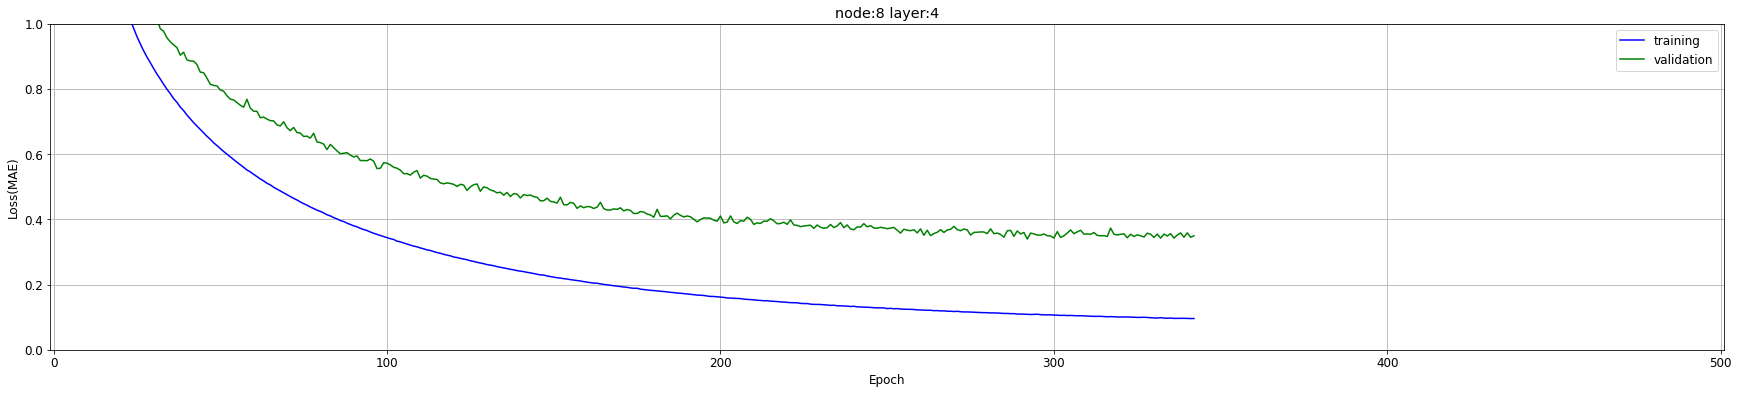

In [80]:
plt.plot(pd.DataFrame(history.history)[['loss']],'b', label='training')
plt.plot(pd.DataFrame(history.history)[['val_loss']],'g', label='validation')
# plt.figure(figsize=(5,5), dpi=10000, facecolor='w', edgecolor='k')
plt.xlabel("Epoch")
plt.ylabel("Loss(MAE)")  # "Loss(MAE)"  logcosh
plt.rcParams['figure.figsize'] = [15, 6]
font = {'weight' : 'normal', 'size' : 12}
plt.rc('font', **font)
plt.title('node:' + str(nodeNum)+' layer:'+str(len(layerNum)))
plt.grid(True)
plt.legend()
plt.xlim(-1, epochNum+1)
plt.ylim(0, 1)
plt.savefig(MODEL_SAVE_FOLDER_PATH+'_lc_'+case_name+'.png', dpi=300)
plt.show()

In [81]:
predict_targets = model.predict(mX_test) #X_test
test_targets = mY_test #Y_test
test_score= model.evaluate(mX_test, mY_test)
test_mae_score = test_score[1]

13563/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Plot: Time-series (Final model)

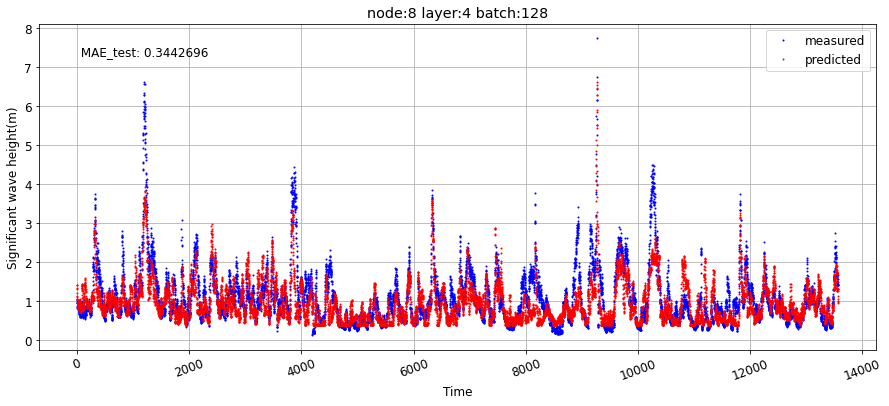

In [82]:
Test_Date_Time = pd.to_datetime(data_test.Date_Time)
plt.plot(test_targets, 'b.',label='measured', markersize=2)
plt.plot(predict_targets,'r.',label='predicted', markersize=2)

plt.title('node:' + str(nodeNum)+' layer:'+str(len(layerNum))+' batch:'+str(batchNum))
plt.ylabel('Significant wave height(m)')
plt.xlabel('Time')
plt.xticks(rotation=20)

plt.rcParams['figure.figsize'] = [30, 6]
plt.grid(True)
plt.legend()
plt.text(0, 7.3, ' MAE_test: '+str(test_mae_score))
# plt.text(0, 7.3, ' MSE_test: '+str(test_mse_score))
plt.savefig(MODEL_SAVE_FOLDER_PATH+'_ts_'+case_name+'.png', dpi=300)
plt.show()

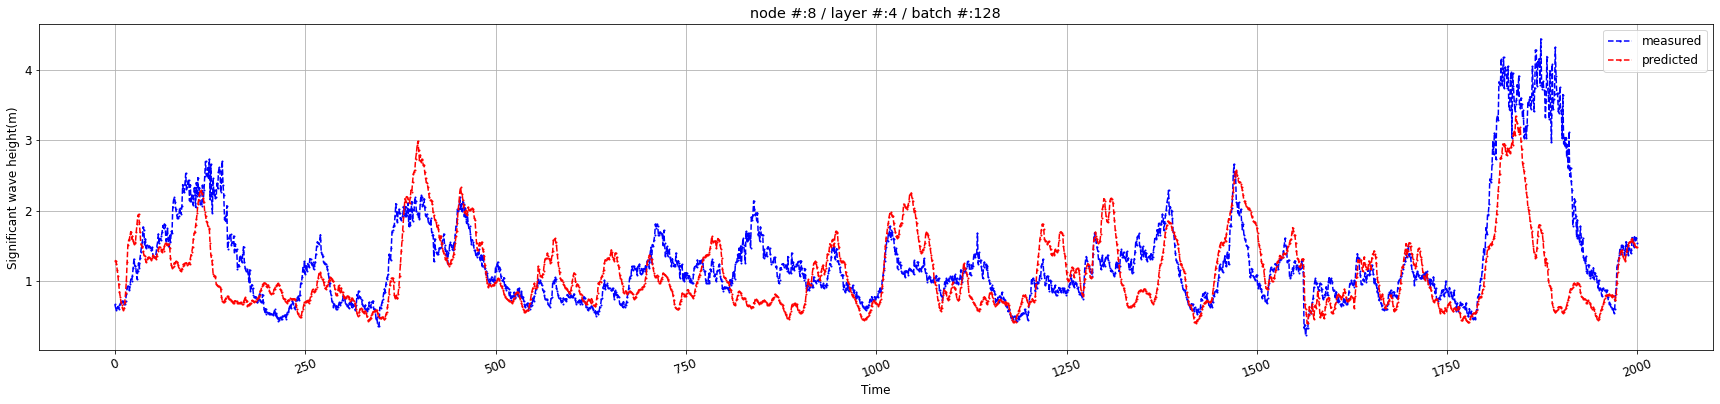

In [83]:
n1 = 2000
n2 = 2000
plt.plot(test_targets[n1:n1+n2], 'b.--',label='measured', markersize=2)
plt.plot(predict_targets[n1:n1+n2],'r.--',label='predicted', markersize=2)
plt.title('node #:' + str(nodeNum)+' / layer #:'+str(len(layerNum))+' / batch #:'+str(batchNum))
plt.ylabel('Significant wave height(m)')
plt.xlabel('Time')
plt.xticks(rotation=20)
plt.rcParams['figure.figsize'] = [30, 6]
plt.grid(True)
plt.legend()
plt.savefig(MODEL_SAVE_FOLDER_PATH+'_tsd_'+case_name+'.png', dpi=300)
plt.show()

## Training Data Set 

In [84]:
predict_mY_train = model.predict(mX_train) #X_test

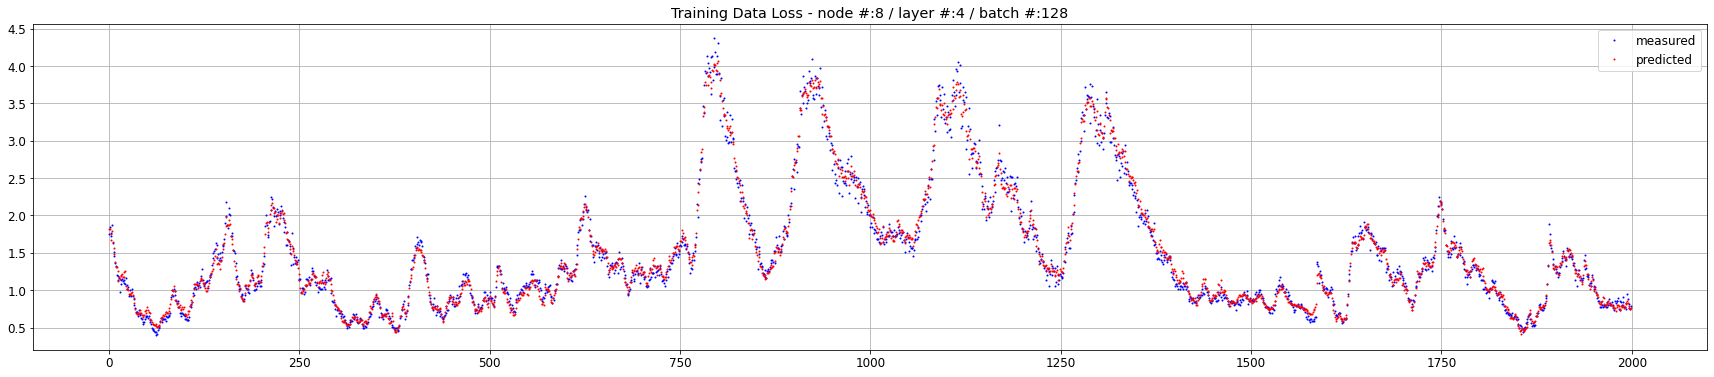

In [85]:
n1 = 1000
n2 = 2000
plt.plot(mY_train[n1:n1+n2], 'b.',label='measured', markersize=2)
plt.plot(predict_mY_train[n1:n1+n2],'r.',label='predicted', markersize=2)
plt.title('Training Data Loss - node #:' + str(nodeNum)+' / layer #:'+str(len(layerNum))+' / batch #:'+str(batchNum))
plt.rcParams['figure.figsize'] = [30, 6]
plt.grid(True)
plt.legend()
plt.show()

## Load best model

In [ ]:
model_list = os.listdir(MODEL_SAVE_FOLDER_PATH)
print(model_list)

In [ ]:
model_list = list(filter(lambda k: 'ocean' in k, model_list))
maxNum=0
for ii in range(len(model_list)):
    if len(model_list[ii].split('-'))>1:
        if int(model_list[ii].split('-')[1])>= maxNum:
            maxNum= int(model_list[ii].split('-')[1])
            maxIdx = ii
model_list[maxIdx]
model_load_path = MODEL_SAVE_FOLDER_PATH+model_list[maxIdx]
print(model_list[maxIdx])
print(model_load_path)

In [ ]:
best_model = keras.models.load_model(model_load_path, )

In [ ]:
# test_mse_score_best, test_mae_score_best = best_model.evaluate(X_test, Y_test)
# test_mae_score_best #test_mae_score_best test_mse_score_best
b = best_model.evaluate(mX_test, mY_test);

In [ ]:
test_mae_score_best = b[1];

In [ ]:
best_predict_targets = best_model.predict(mX_test);

In [ ]:
best_predict_targets.shape

In [ ]:
test_mae_score_best #test_mse_score_best

## Plot: Time-series (Best model)

In [ ]:
plt.plot(test_targets, 'b.',label='measured', markersize=2)
plt.plot(best_predict_targets,'r.',label='predicted', markersize=2)
plt.title('node #:' + str(nodeNum)+' / layer:'+str(layerNum))
plt.ylabel('Significant wave height(m)')
plt.xlabel('Time')
plt.xticks(rotation=20)
plt.rcParams['figure.figsize'] = [15, 6]
plt.grid(True)
plt.legend()
plt.text(0, 7.3, ' MAE_test: '+str(test_mae_score_best))
# plt.text(0, 7.3, ' MSE_test: '+str(test_mse_score_best))
plt.savefig(MODEL_SAVE_FOLDER_PATH+'tsb_'+case_name+'.png', dpi=300)
plt.show()

In [ ]:
np.savetxt(MODEL_SAVE_FOLDER_PATH+case_name+'.txt',(best_predict_targets),header = 'Sig.wave height (m)')

In [ ]:
MODEL_SAVE_FOLDER_PATH+case_name+'.txt'

## keras.sequence test

In [ ]:
def relu(X):
   return np.maximum(0,X)

In [ ]:
weights = model.get_weights()
#print(weights)

In [ ]:
print(np.array_str(weights[0], precision=2, suppress_small=True))

In [ ]:
print(np.array_str(weights[1], precision=2, suppress_small=True))

In [ ]:
n=5
x=X_test[0:n,:]
print(X_test.shape)
print(np.array_str(x, precision=2, suppress_small=True))

In [ ]:
yp = model.predict(x)
print(np.array_str(yp, precision=2, suppress_small=True))

In [ ]:
yt = Y_test[0:n]
print(np.array_str((yt.reshape(n,1)), precision=2, suppress_small=True))

In [ ]:
print(np.array_str((yt.reshape(n,1)-yp), precision=2, suppress_small=True))

In [ ]:
l0=np.matmul(x, weights[0])
print(np.array_str(l0, precision=2, suppress_small=True))

In [ ]:
l0=l0+weights[1]
print(np.array_str(l0, precision=2, suppress_small=True))

In [ ]:
l00=relu(l0)
print(np.array_str(l00, precision=2, suppress_small=True))

In [ ]:
l1=np.matmul(l00, weights[2])+weights[3]
print(np.array_str(l1, precision=2, suppress_small=True))